# Model (Random Forest) + PFI

In [135]:
# Data: PCA scores + printer labels
pc_scores <- transformed_jfpca$fpca_res$coef %>%
  as.data.frame() %>%
  mutate(curve = colnames(sim_matrix)) %>%
  mutate(printer = as.factor(gsub("P(.*)_R.*", "\\1", curve))) %>%
  select(printer, everything(), -curve)

## Set up

In [138]:
# K-fold setup
set.seed(36)
k_folds <- k_folds_value 
folds <- createFolds(pc_scores$printer, k = k_folds, list = TRUE)

In [141]:
# Tree list
trees_list <- trees_list_values

# PC list
K_set <- K_set_values

In [144]:
n_pc <- ncol(pc_scores) - 1   
cat("Number of used PCs =", n_pc)

Number of used PCs = 75

## Cross validation (K-fold)

In [146]:
 # Save Metric + PFI
cv_results <- data.frame(K = integer(), Fold = integer(), Trees = integer(), Metric = numeric())
pfi_results <- list()

# Flexible metric function
compute_metric <- function(y_true, pred_prob, pred_class, metric_name) {
  eps <- 1e-15
  if (metric_name == "logloss") {
    probs_true <- sapply(seq_len(length(y_true)), function(i) pred_prob[i, y_true[i]])
    return(-mean(log(pmax(probs_true, eps))))
  }
  if (metric_name == "accuracy") {
    return(mean(pred_class == y_true))
  }
}

# CROSS-VALIDATION + PFI
for (K in K_set) {
  cat("\n==========================\n")
  cat("📌 Using", K, "Principal Components\n")
  cat("==========================\n")

  pc_cols <- colnames(pc_scores)[grepl("^V", colnames(pc_scores))][1:K]

  for (k in 1:k_folds) {
    cat("\n🌟 Fold", k, "...\n")
    test_idx <- folds[[k]]
    train_data <- pc_scores[-test_idx, c("printer", pc_cols)]
    test_data  <- pc_scores[test_idx,  c("printer", pc_cols)]

    for (nt in trees_list) {
      set.seed(36 + k + nt + K)

      model_rf <- randomForest(printer ~ ., data = train_data, ntree = nt)

      pred_prob  <- predict(model_rf, newdata = test_data, type = "prob")
      pred_class <- predict(model_rf, newdata = test_data, type = "response")

      metric_value <- compute_metric(test_data$printer, pred_prob, pred_class, metric_name)

      cv_results <- rbind(cv_results, data.frame(
        K = K, Fold = k, Trees = nt, Metric = metric_value
      ))

      cat("  trees:", nt, "|", metric_name, "=", round(metric_value, 4), "\n")

      # ---- PFI ----
      pfi_obj <- compute_pfi(
        x = train_data %>% select(-printer),
        y = train_data$printer,
        f = model_rf,
        metric = metric_name,
        K = 3  
      )

      pfi_results[[paste0("K",K,"_Fold",k,"_Trees",nt)]] <- data.frame(
        K = K, Fold = k, Trees = nt,
        PC = pc_cols, PFI = pfi_obj$pfi
      )
    }
  }
}

# SUMMARY 
pfi_df <- bind_rows(pfi_results)

pfi_summary <- pfi_df %>%
  group_by(K, Trees, PC) %>%
  summarise(Mean_PFI = mean(PFI), .groups = "drop") %>%
  arrange(desc(Mean_PFI))

summary_results <- cv_results %>%
  group_by(K, Trees) %>%
  summarise(
    Mean = mean(Metric),
    SD   = sd(Metric),
    .groups = "drop"
  )

# Rename
if (metric_name == "accuracy") {
  colnames(summary_results)[3:4] <- c("Mean_Accuracy", "SD_Accuracy")
} else {
  colnames(summary_results)[3:4] <- c("Mean_LogLoss", "SD_LogLoss")
}

print(summary_results)



📌 Using 10 Principal Components

🌟 Fold 1 ...
  trees: 50 | logloss = 0.5271 
  trees: 100 | logloss = 0.5112 
  trees: 300 | logloss = 0.4987 
  trees: 500 | logloss = 0.5051 

🌟 Fold 2 ...
  trees: 50 | logloss = 0.4197 
  trees: 100 | logloss = 0.4491 
  trees: 300 | logloss = 0.4398 
  trees: 500 | logloss = 0.4439 

🌟 Fold 3 ...
  trees: 50 | logloss = 0.4577 
  trees: 100 | logloss = 0.439 
  trees: 300 | logloss = 0.4293 
  trees: 500 | logloss = 0.4283 

🌟 Fold 4 ...
  trees: 50 | logloss = 0.4278 
  trees: 100 | logloss = 0.4183 
  trees: 300 | logloss = 0.4216 
  trees: 500 | logloss = 0.422 

🌟 Fold 5 ...
  trees: 50 | logloss = 0.5355 
  trees: 100 | logloss = 0.5579 
  trees: 300 | logloss = 0.534 
  trees: 500 | logloss = 0.5291 

📌 Using 20 Principal Components

🌟 Fold 1 ...
  trees: 50 | logloss = 0.7441 
  trees: 100 | logloss = 0.7451 
  trees: 300 | logloss = 0.726 
  trees: 500 | logloss = 0.7509 

🌟 Fold 2 ...
  trees: 50 | logloss = 0.7316 
  trees: 100 | logloss

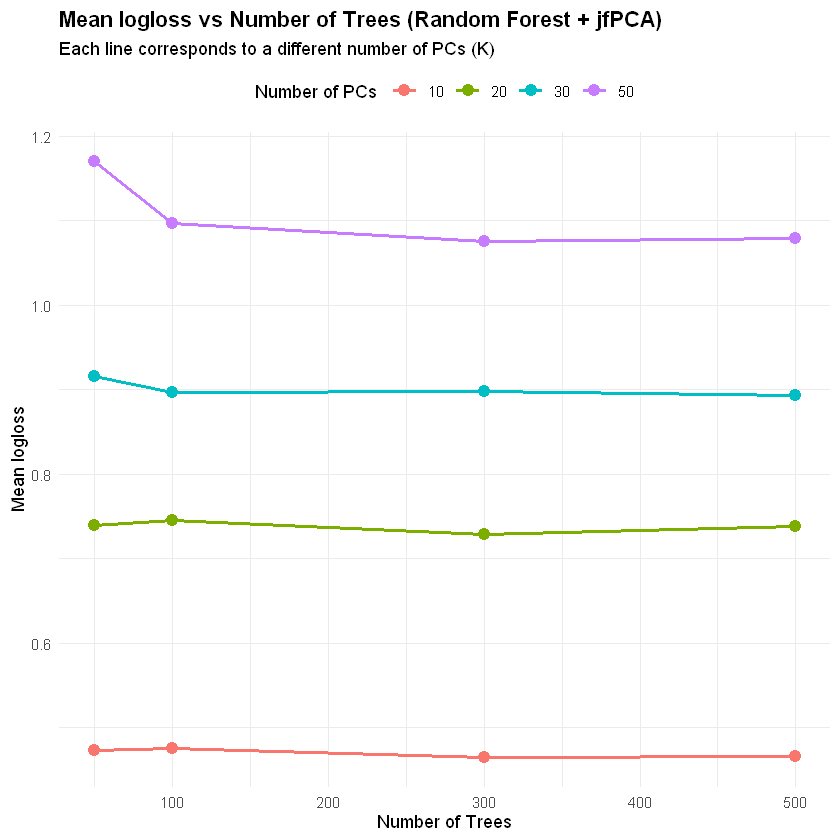

In [148]:
# Automatically select the correct metric column for plotting (accuracy / logloss)
metric_col <- if (metric_name == "accuracy") "Mean_Accuracy" else "Mean_LogLoss"

# Plot for ALL tested numbers of PCs 
ggplot(summary_results, 
       aes_string(x = "Trees", y = metric_col, color = "factor(K)", group = "factor(K)")) +
  geom_line(size = 1) +
  geom_point(size = 3) +
  labs(
    title = paste("Mean", metric_name, "vs Number of Trees (Random Forest + jfPCA)"),
    subtitle = "Each line corresponds to a different number of PCs (K)",
    x = "Number of Trees",
    y = paste("Mean", metric_name),
    color = "Number of PCs"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold"),
    legend.position = "top"
  )



===================== 📌 TEXT OUTPUT =====================

📌 K = 10 | 🌳 Trees = 50 
# A tibble: 10 × 3
    rank PC    Mean_PFI
   <int> <chr>    <dbl>
 1     1 V1     0.0144 
 2     2 V3     0.0114 
 3     3 V2     0.0109 
 4     4 V4     0.00835
 5     5 V6     0.00454
 6     6 V5     0.00367
 7     7 V9     0.00309
 8     8 V10    0.00210
 9     9 V8     0.00174
10    10 V7     0.00153

📌 K = 10 | 🌳 Trees = 100 
# A tibble: 10 × 3
    rank PC    Mean_PFI
   <int> <chr>    <dbl>
 1     1 V1     0.0134 
 2     2 V3     0.0132 
 3     3 V2     0.0104 
 4     4 V4     0.00713
 5     5 V6     0.00432
 6     6 V9     0.00349
 7     7 V5     0.00331
 8     8 V10    0.00317
 9     9 V7     0.00153
10    10 V8     0.00144

📌 K = 10 | 🌳 Trees = 300 
# A tibble: 10 × 3
    rank PC    Mean_PFI
   <int> <chr>    <dbl>
 1     1 V1     0.0135 
 2     2 V3     0.0135 
 3     3 V2     0.0104 
 4     4 V4     0.00670
 5     5 V6     0.00426
 6     6 V9     0.00328
 7     7 V5     0.00316
 8     8 V10

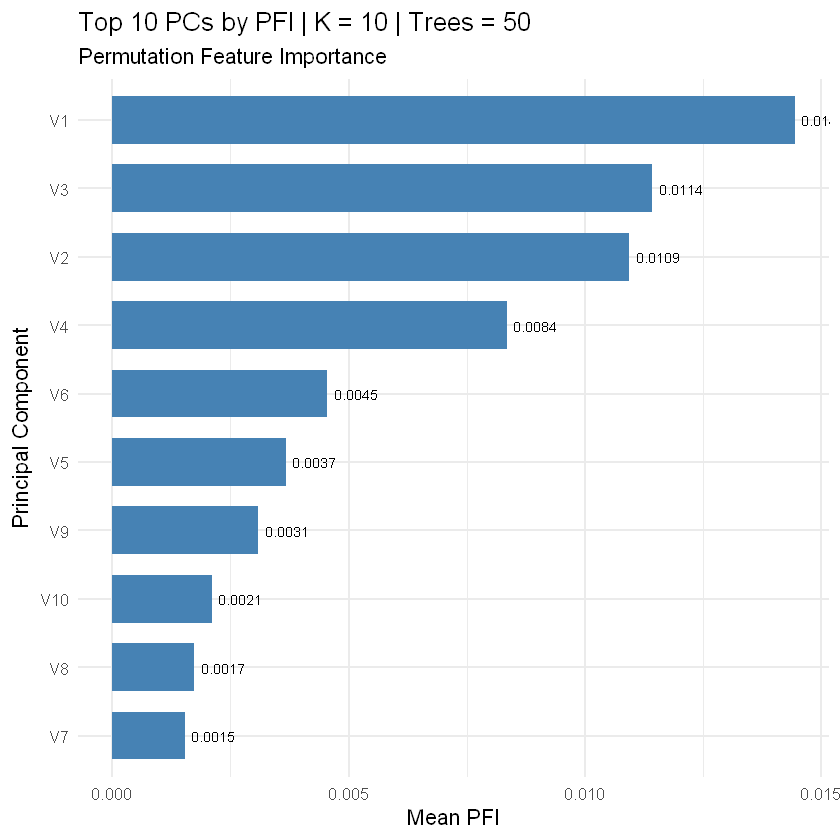

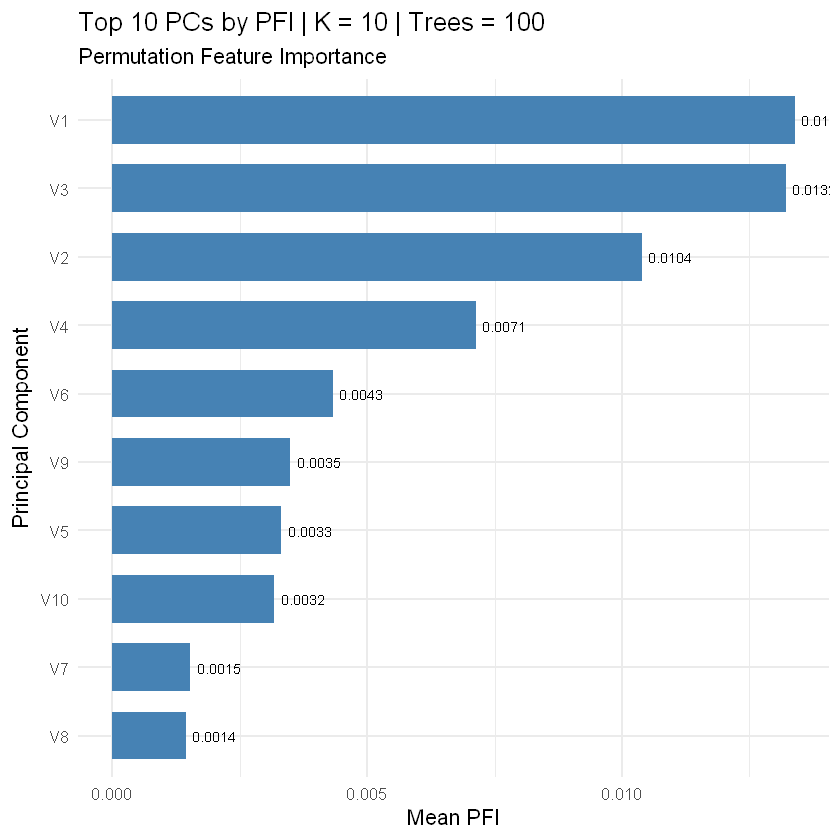

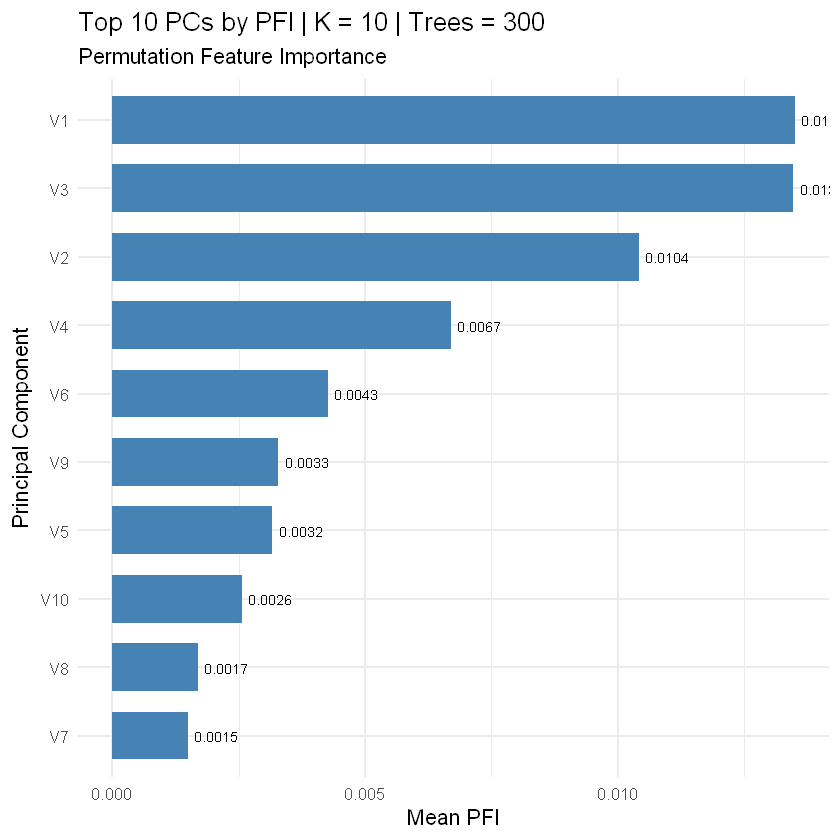

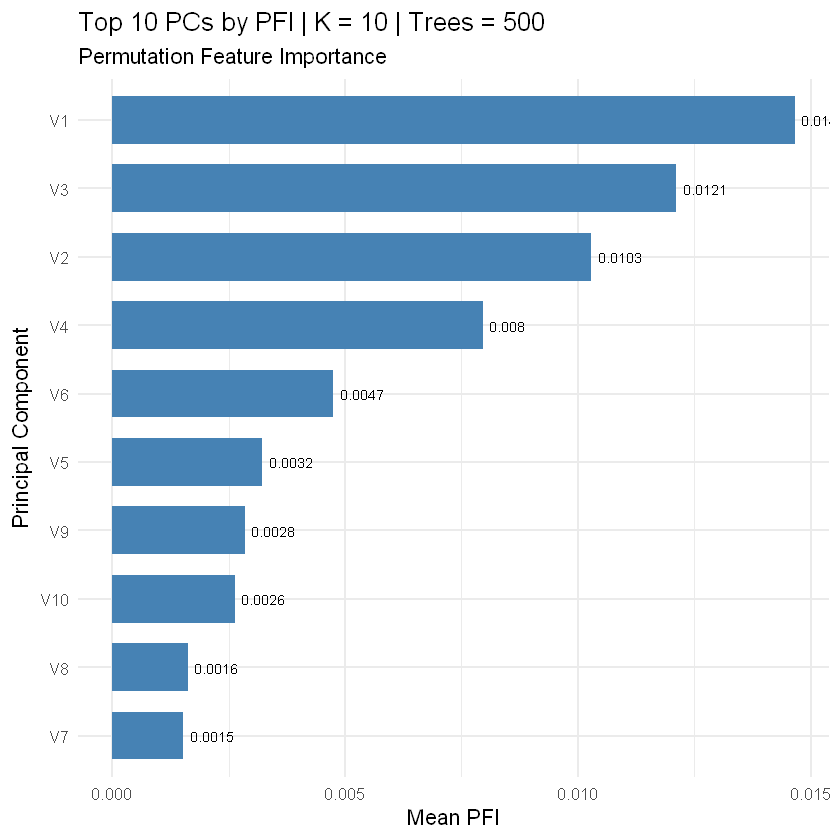

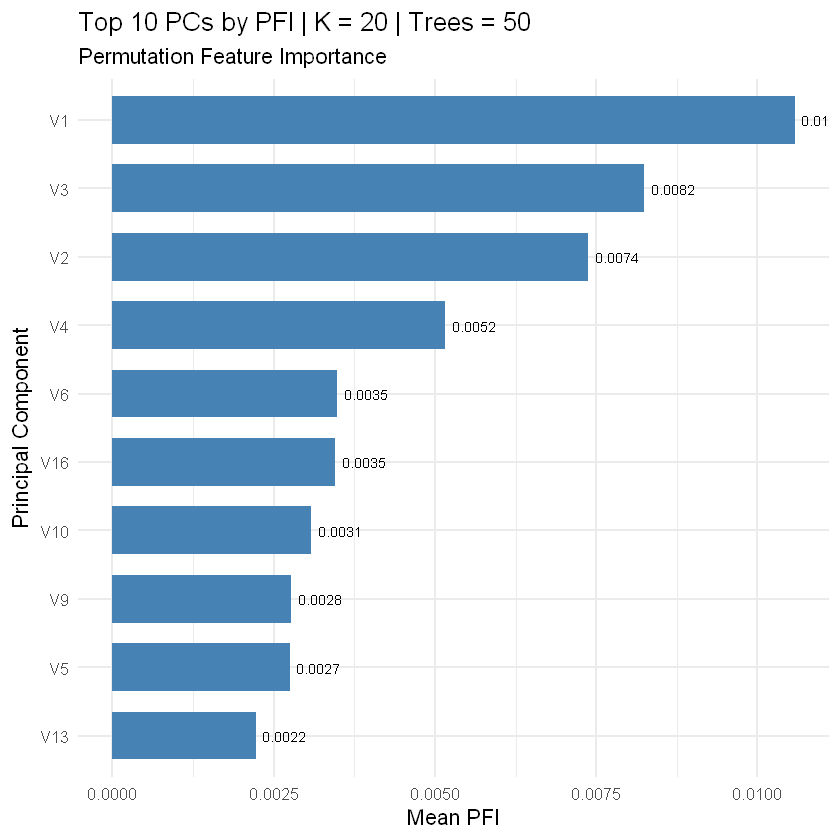

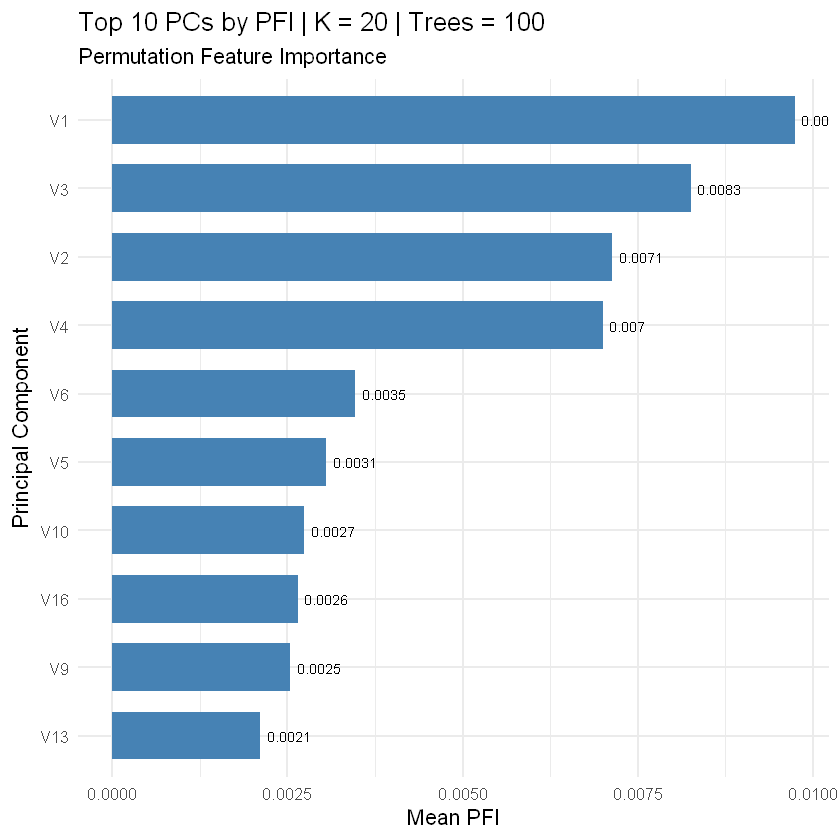

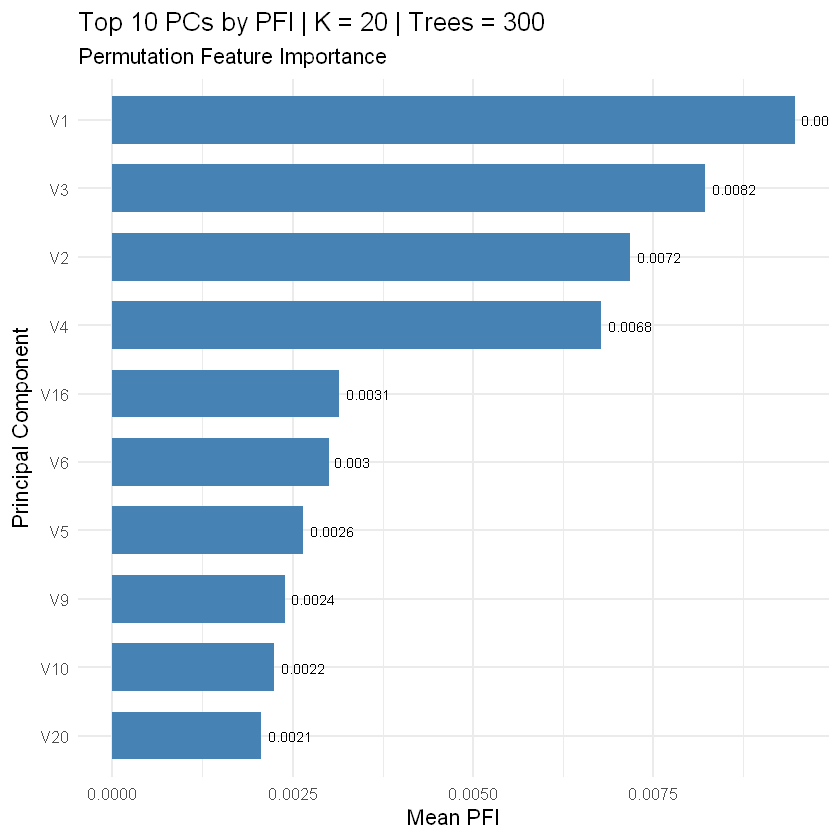

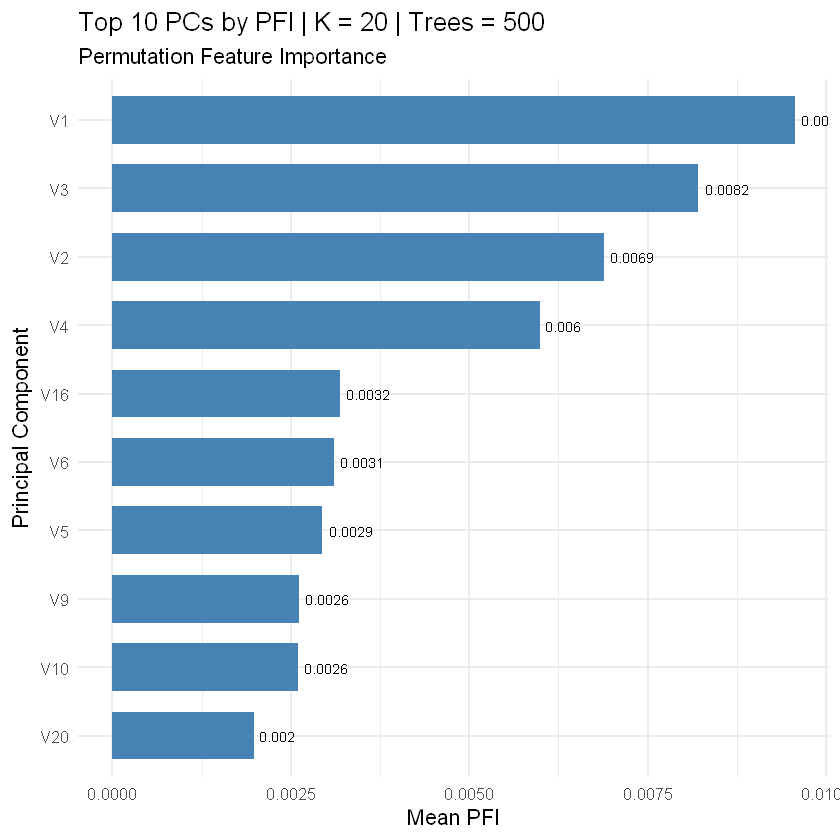

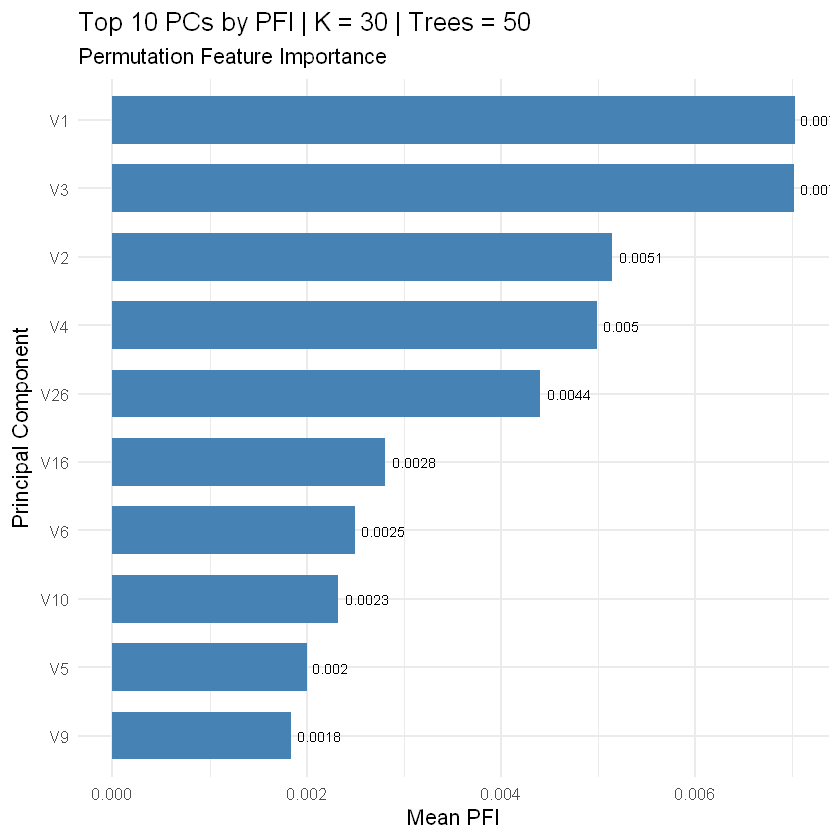

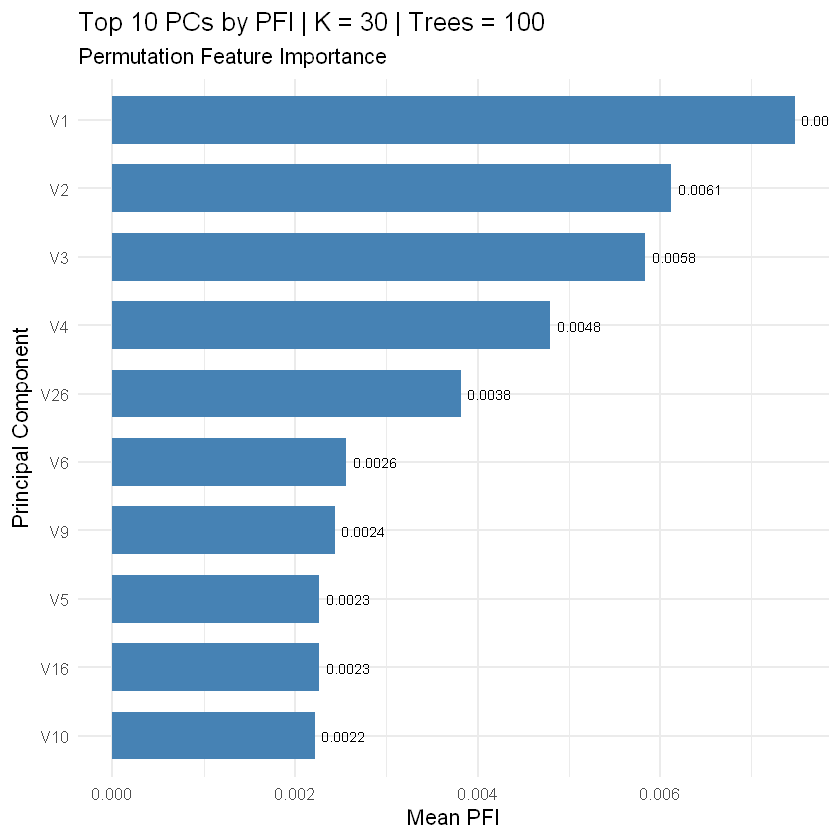

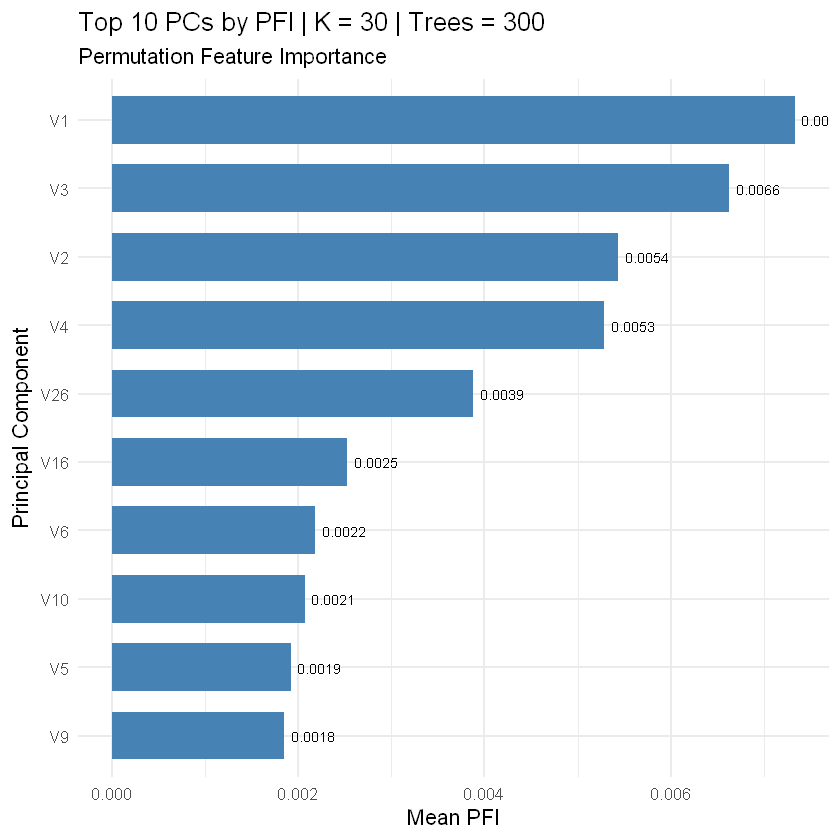

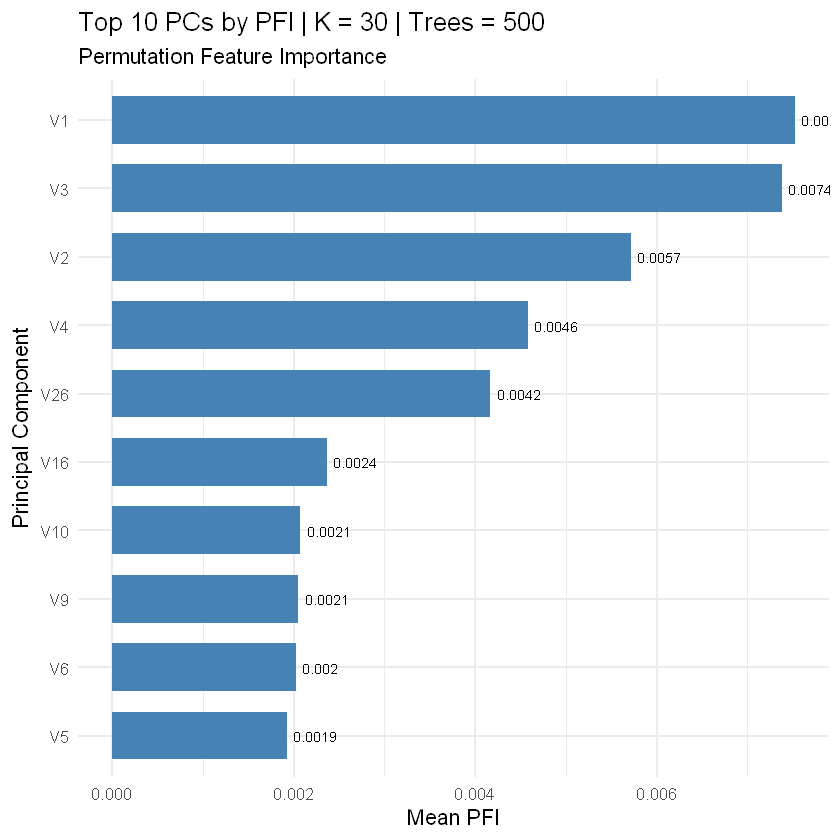

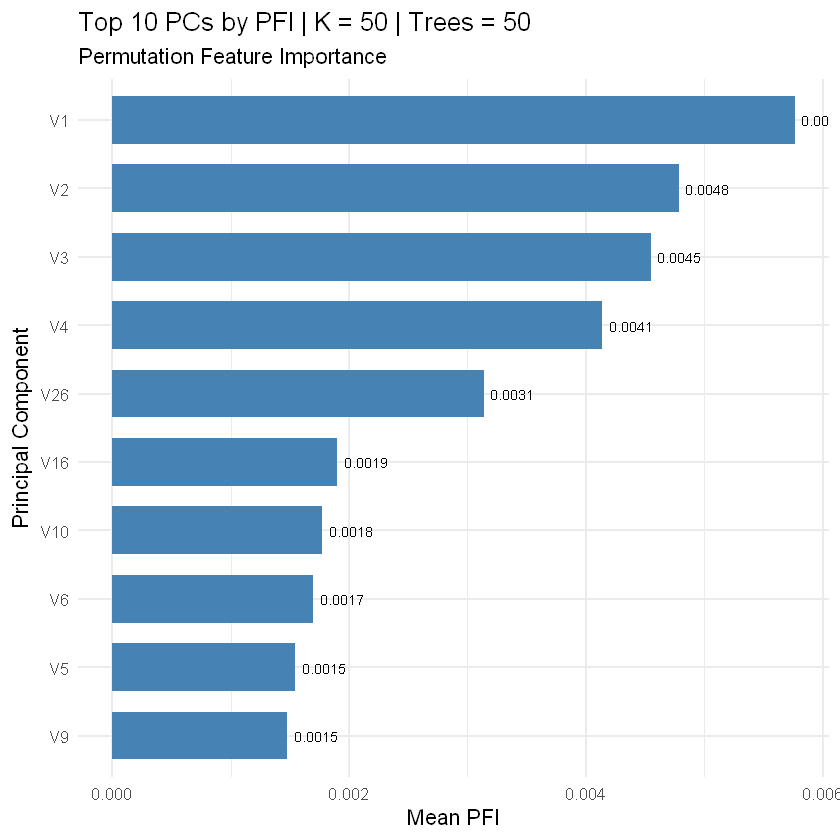

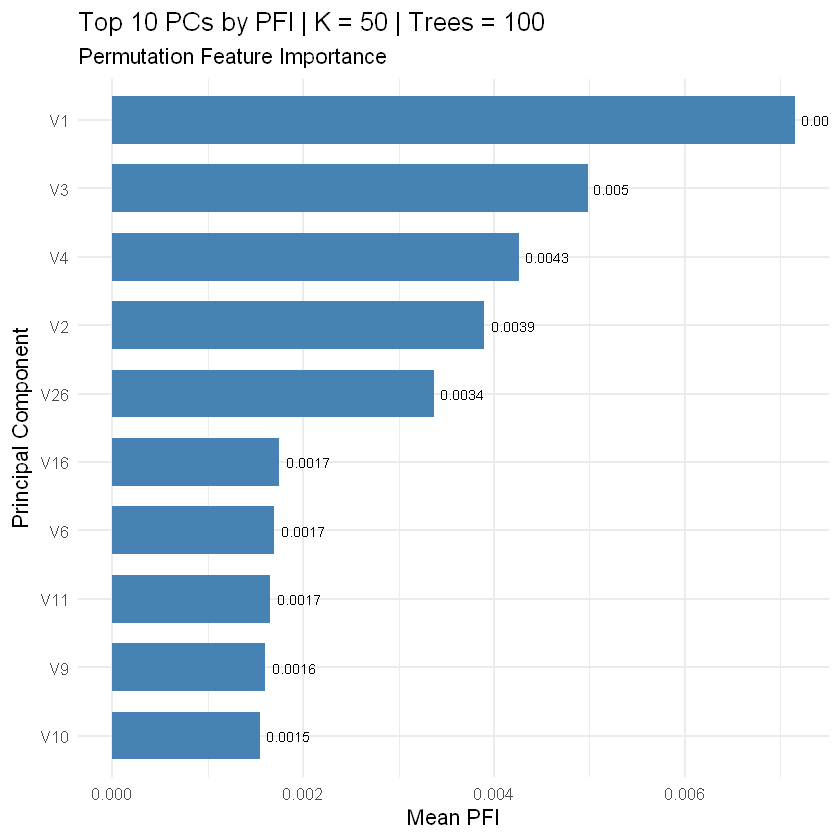

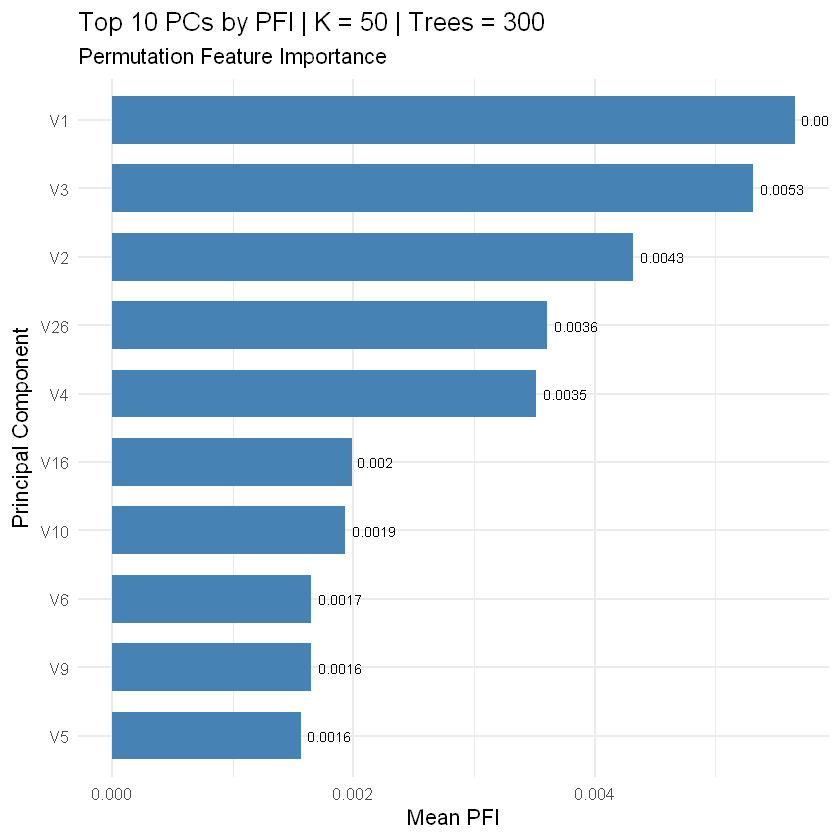

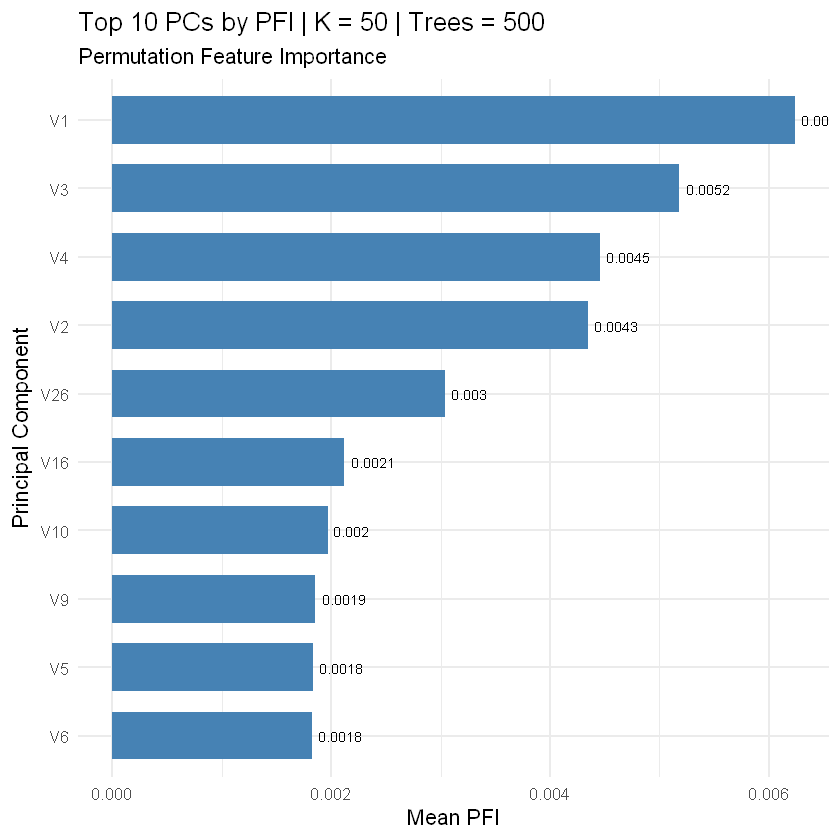

In [149]:
# LIST to store all TEXT + PLOT for each (K, Trees)
output_list <- list()

generate_output <- function(K_value, tree_value) {
  top_pfi <- pfi_summary %>%
    filter(K == K_value, Trees == tree_value) %>%   # ⚠ filter by both K and Trees
    arrange(desc(Mean_PFI)) %>%
    head(10) %>%
    mutate(rank = row_number()) %>%
    select(rank, PC, Mean_PFI)

  key <- paste0("K", K_value, "_Trees", tree_value)

  output_list[[key]] <<- list(
    text = top_pfi,
    plot = ggplot(top_pfi, aes(x = reorder(PC, Mean_PFI), y = Mean_PFI)) +
      geom_col(fill = "steelblue", width = 0.7) +
      geom_text(aes(label = round(Mean_PFI, 4)), hjust = -0.15, size = 3) +
      coord_flip() +
      labs(
        title = paste("Top 10 PCs by PFI | K =", K_value, "| Trees =", tree_value),
        subtitle = "Permutation Feature Importance",
        x = "Principal Component",
        y = "Mean PFI"
      ) +
      theme_minimal(base_size = 13)
  )
}

# Save all outputs to list
for (K_val in K_set) {
  for (nt in trees_list) {
    generate_output(K_val, nt)
  }
}

# PRINT ALL TEXT FIRST
cat("\n===================== 📌 TEXT OUTPUT =====================\n")
for (K_val in K_set) {
  for (nt in trees_list) {
    key <- paste0("K", K_val, "_Trees", nt)
    cat("\n📌 K =", K_val, "| 🌳 Trees =", nt, "\n")
    print(output_list[[key]]$text)
  }
}

# PRINT ALL PLOTS AFTER TEXT
cat("\n===================== 📊 PLOT OUTPUT =====================\n")
for (K_val in K_set) {
  for (nt in trees_list) {
    key <- paste0("K", K_val, "_Trees", nt)
    print(output_list[[key]]$plot)
  }
}
